In [79]:
import random
import math as mt
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

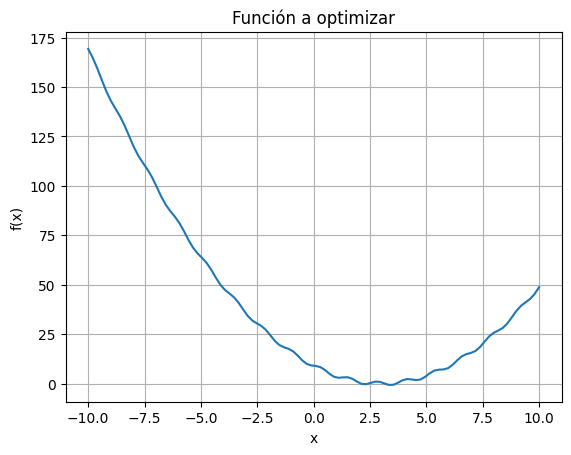

In [80]:


def funcion(x):
    return ((x-3)**2) + np.sin(5*x)



# Dominio de busqueda
imax = 10
imin = -imax



x = np.linspace(imin, imax, 100)
y = funcion(x)


plt.plot(x, y)
plt.title("Función a optimizar")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid()
plt.show()



In [81]:
xmin, xmax = -5, 5
N = 50  # número de nodos
xs = np.linspace(xmin, xmax, N)
fx = funcion(xs)

fx = fx - fx.min() + 1e-6



NODO_INICIO = 1
NODO_FINAL = 4
TODOS_NODOS = [1, 2, 3, 4, 5, 6, 7]
NUM_NODOS = len(TODOS_NODOS)

# --- 2. PARÁMETROS ACO ---
NUM_HORMIGAS = 50
NUM_ITERACIONES = 100
RHO = 0.01       # Tasa de evaporación
Q = 1.0          # Constante de depósito de feromona
ALFA = 1.0       # Influencia del rastro de feromona
BETA = 1.0       # Influencia de la heurística (visibilidad)


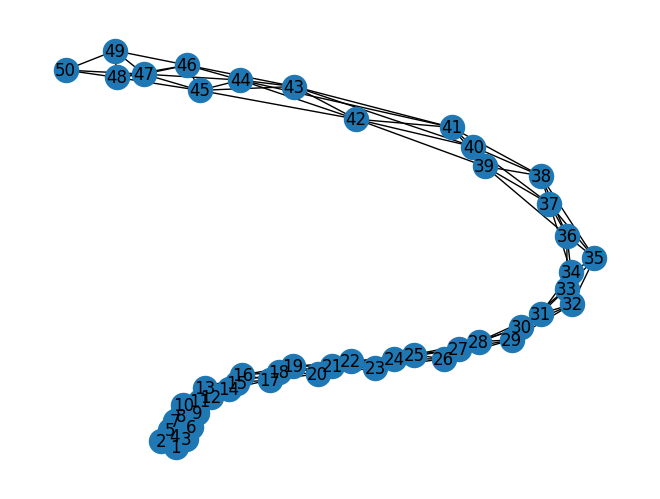

{1: {2: 12.995982646901943, 3: 25.41312923460403, 4: 37.09927451958727},
 2: {3: 12.417146587702083, 4: 24.103291872685325, 5: 35.00034263725271},
 3: {4: 11.68614528498324, 5: 22.583196049550622, 6: 32.798767044280616},
 4: {5: 10.897050764567384, 6: 21.112621759297376, 7: 30.83359224519917},
 5: {6: 10.215570994729994, 7: 19.93654148063179, 8: 29.26699629906814},
 6: {7: 9.720970485901796, 8: 19.051425304338146, 9: 27.929578824729866},
 7: {8: 9.33045481843635, 9: 18.20860833882807, 10: 26.48196282926923},
 8: {9: 8.87815352039172, 10: 17.151508010832877, 11: 24.73854806805642},
 9: {10: 8.27335449044116, 11: 15.8603945476647, 12: 22.84456695624975},
 10: {11: 7.587040057223542, 12: 14.57121246580859, 13: 21.13753810460915},
 11: {12: 6.9841724085850485, 13: 13.550498047385608, 14: 19.825285788724518},
 12: {13: 6.566325638800559, 14: 12.841113380139468, 15: 18.787683116863512},
 13: {14: 6.274787741338909, 15: 12.221357478062952, 16: 17.69124873405506},
 14: {15: 5.946569736724043, 

In [82]:

def construir_grafo(xs, fx, k=3):
    grafo = {}
    dx = xs[1] - xs[0]
    N = len(xs)
    for i in range(N):
        grafo[i+1] = {}
        for step in range(1, k+1):
            j = i + step
            if j < N:
                # costo = área bajo la curva entre x_i y x_j (regla del trapecio)
                costo = np.sum(0.5 * (fx[i:j] + fx[i+1:j+1]) * dx)
                grafo[i+1][j+1] = float(costo)
    return grafo

GRAFO_DISTANCIAS = construir_grafo(xs, fx)



grafo = nx.Graph()
for i in GRAFO_DISTANCIAS:
    for j in GRAFO_DISTANCIAS[i]:
        grafo.add_edge(i, j, weight=GRAFO_DISTANCIAS[i][j])
nx.draw(grafo, with_labels=True)
plt.show()
GRAFO_DISTANCIAS



In [83]:

# --- 3. FUNCIONES PRINCIPALES ---

def inicializar_feromonas(grafo):
    feromonas = {}
    for i in grafo:
        feromonas[i] = {}
        for j in grafo[i]:
            feromonas[i][j] = 0.1  # valor inicial
    return feromonas


def probabilidad_movimiento(actual, nodos_no_visitados, feromonas, grafo, alpha, beta):
    total = 0.0
    probabilidades = {}

    # Calcula el denominador (la suma de todos los pesos posibles)
    for siguiente in nodos_no_visitados:
        if siguiente in grafo[actual]:
            tau = feromonas[actual][siguiente]
            eta = 1.0 / grafo[actual][siguiente]
            total += (tau ** alpha) * (eta ** beta)

    # Calcula la probabilidad normalizada para cada destino
    for siguiente in nodos_no_visitados:
        if siguiente in grafo[actual]:
            tau = feromonas[actual][siguiente]
            eta = 1.0 / grafo[actual][siguiente]
            prob = ((tau ** alpha) * (eta ** beta)) / total
            probabilidades[siguiente] = prob

    return probabilidades


def seleccionar_nodo(probabilidades):
    r = random.random()
    acumulada = 0.0
    for nodo, prob in probabilidades.items():
        acumulada += prob
        if r <= acumulada:
            return nodo
    # Si por redondeo no se elige ninguno
    return list(probabilidades.keys())[-1]


def construir_ruta(feromonas, grafo, alpha, beta):
    ruta = [NODO_INICIO]
    actual = NODO_INICIO
    nodos_no_visitados = TODOS_NODOS.copy()
    nodos_no_visitados.remove(actual)

    while actual != NODO_FINAL and len(nodos_no_visitados) > 0:
        probabilidades = probabilidad_movimiento(actual, nodos_no_visitados, feromonas, grafo, alpha, beta)
        if not probabilidades:
            break
        siguiente = seleccionar_nodo(probabilidades)
        ruta.append(siguiente)
        actual = siguiente
        if siguiente in nodos_no_visitados:
            nodos_no_visitados.remove(siguiente)

    return ruta


def calcular_longitud_ruta(ruta, grafo):
    distancia = 0.0
    for i in range(len(ruta) - 1):
        a, b = ruta[i], ruta[i+1]
        if b in grafo[a]:
            distancia += grafo[a][b]
        else:
            # Si no existe conexión directa, penalizamos
            distancia += 9999
    return distancia


def actualizar_feromonas(feromonas, rutas, distancias, rho, q):
    # Evaporación
    for i in feromonas:
        for j in feromonas[i]:
            feromonas[i][j] *= (1 - rho)

    # Deposito de feromonas
    for k in range(len(rutas)):
        ruta = rutas[k]
        dist = distancias[k]
        for i in range(len(ruta) - 1):
            a, b = ruta[i], ruta[i+1]
            if b in feromonas[a]:
                feromonas[a][b] += q / dist


def aco():
    feromonas = inicializar_feromonas(GRAFO_DISTANCIAS)
    mejor_ruta = None
    mejor_distancia = mt.inf

    for iteracion in range(NUM_ITERACIONES):
        rutas = []
        distancias = []

        for i in range(NUM_HORMIGAS):
            ruta = construir_ruta(feromonas, GRAFO_DISTANCIAS, ALFA, BETA)
            distancia = calcular_longitud_ruta(ruta, GRAFO_DISTANCIAS)
            rutas.append(ruta)
            distancias.append(distancia)

            if distancia < mejor_distancia and ruta[-1] == NODO_FINAL:
                mejor_ruta = ruta
                mejor_distancia = distancia

        actualizar_feromonas(feromonas, rutas, distancias, RHO, Q)

        print(f"Iteración {iteracion+1}: Mejor distancia = {mejor_distancia:.3f}")

    print("\n--- RESULTADO FINAL ---")
    print(f"Mejor ruta encontrada: {mejor_ruta}")
    print(f"Distancia total: {mejor_distancia:.3f}")


# --- 4. EJECUCIÓN ---
if __name__ == "__main__":
    aco()


Iteración 1: Mejor distancia = 37.099
Iteración 2: Mejor distancia = 37.099
Iteración 3: Mejor distancia = 37.099
Iteración 4: Mejor distancia = 37.099
Iteración 5: Mejor distancia = 37.099
Iteración 6: Mejor distancia = 37.099
Iteración 7: Mejor distancia = 37.099
Iteración 8: Mejor distancia = 37.099
Iteración 9: Mejor distancia = 37.099
Iteración 10: Mejor distancia = 37.099
Iteración 11: Mejor distancia = 37.099
Iteración 12: Mejor distancia = 37.099
Iteración 13: Mejor distancia = 37.099
Iteración 14: Mejor distancia = 37.099
Iteración 15: Mejor distancia = 37.099
Iteración 16: Mejor distancia = 37.099
Iteración 17: Mejor distancia = 37.099
Iteración 18: Mejor distancia = 37.099
Iteración 19: Mejor distancia = 37.099
Iteración 20: Mejor distancia = 37.099
Iteración 21: Mejor distancia = 37.099
Iteración 22: Mejor distancia = 37.099
Iteración 23: Mejor distancia = 37.099
Iteración 24: Mejor distancia = 37.099
Iteración 25: Mejor distancia = 37.099
Iteración 26: Mejor distancia = 37